I’m currently thinking hard about adding some isolation to our house. To get started on this not so simple problem, I’ve turned to an amazing book, about energy in general: David JC MacKay’s **Sustainable Energy – without the hot air** (see [here](http://www.withouthotair.com/Contents.html), a free read!).

It turns down that a relatively simple model can be used to analyze the thermal leakiness properties of a house, based on the knowledge of its surfaces in contact with the outside, the thermostat setting and local temperatures as a function of the year.

The physics and math boil down to the following formula (details in [MacKay’s Appendix E](http://www.withouthotair.com/cE/page_289.shtml)):

$$
\text{energy lost (kWh)} = \text{leakiness of house (W/°C)} * \text{temperature demand (°C $\cdot$ days)} * \text{hours of heating per day (hours/day) / 1000 (W per kW)} 
$$

To get a little bit more into details:
- the leakiness of the house is a function of its surfaces and the materials they are made of, which each have a different thermal resistance (i.e. a number that says how slowly the heat is transferred through them)
- the temperature demand is the relative gap between the thermostat setting of the house user and the outside temperature (which depends on the house location)
- the number of hours of heating per day is set by the house user

In this blog post, we will evaluate all of the terms in the above equation to obtain a value of energy lost to the outside for my house in Orsay, France. First, we will evaluate the temperature demand. Then, the house leakiness. And finally, get an estimate on the total heat loss.

# Part 1: computing the temperature demand as a function of thermostat setting

The first quantity we want to compute is called, following MacKay, *temperature demand*. It is computed by multiplying the difference in temperature $\Delta T$ by a duration $\Delta t$. To quote his example:

> For example, if your house interior is at 18 °C, and the outside temperature is 8 °C for a week, then we say that that week contributed 10 × 7 = 70 degree-days to the (ΔT ×duration) sum.

Enedis, the company in charge of maintaining the French electric grid provides half-hourly temperature time-series that we can use (see [here](https://data.enedis.fr/pages/accueil/?id=dataviz-donnees-de-temperature-et-de-pseudo-rayonnement-en-j2)). Alternatively, we could probably have used the PVGIS database from the European Commission ([here](https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis_en)). Using the `download_data.py` script creates a data file, that once downloaded can be loaded and displayed.

The plot below shows the data over the last 5 years as well as a thermostat setting. It highlights (in red) the temperature demand, i.e. the difference to the outside temperature that needs to be compensated by heat production.

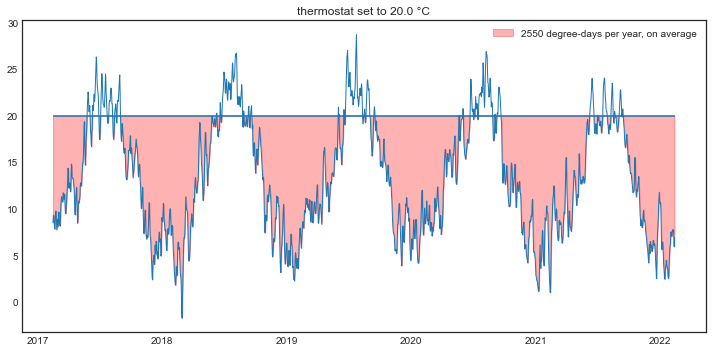

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("seaborn-white")
%matplotlib inline

# we group and average to get a daily temperature value (scaled down from hourly data)
df = pd.read_csv("data.csv", encoding="ansi", delimiter=";", decimal=",").groupby(by="Année-Mois-Jour").mean()
df.index = pd.to_datetime(df.index)
df.head()

# let’s plot the temperature as well as the integral between the outside temperature 
# and our target thermostat

thermostat_setting = 20.
temp_vals = df["Température réalisée lissée (°C)"].values
x = df.index
y1 = temp_vals * 0 + thermostat_setting
y2 = np.min(np.c_[temp_vals, y1], axis=1)

area = np.trapz(thermostat_setting - y2, np.arange(y2.size), dx=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, temp_vals, lw=1)
ax.hlines(thermostat_setting, df.index[0], df.index[-1])
ax.fill_between(x, y2, y1, color="red", alpha=0.3, label=f"{area / 5:.0f} degree-days per year, on average")
ax.set_title(f"thermostat set to {thermostat_setting} °C")
ax.legend()
plt.tight_layout()

I’ve used the full data in the above plot and averaged the temperature demand. As we can read on the plot, the average temperature demand is 2550 degree-days. This corresponds to a 7 degree difference between a thermostat set to 20°C and the outside, which seems reasonable.

What does this plot look like if we restrict it to last year?

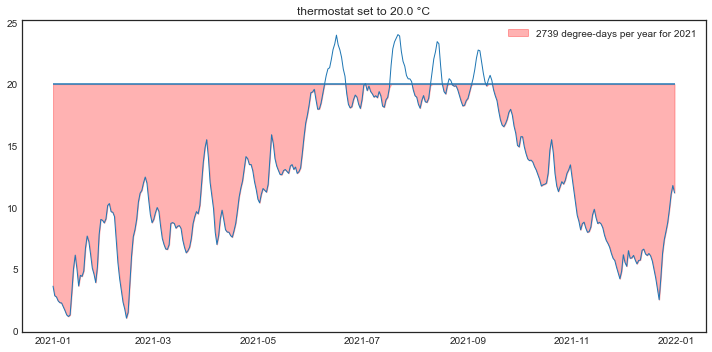

In [2]:
sel = (df.index >= pd.Timestamp("2021-01-01")) & (df.index <= pd.Timestamp("2021-12-31"))  
temp_vals = df["Température réalisée lissée (°C)"][sel].values
x = df.index[sel]
y1 = temp_vals * 0 + thermostat_setting
y2 = np.min(np.c_[temp_vals, y1], axis=1)

area = np.trapz(thermostat_setting - y2, np.arange(y2.size), dx=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, temp_vals, lw=1)
ax.hlines(thermostat_setting, x[0], x[-1])
ax.fill_between(x, y2, y1, color="red", alpha=0.3, label=f"{area:.0f} degree-days per year for 2021")
ax.set_title(f"thermostat set to {thermostat_setting} °C")
ax.legend()
plt.tight_layout()

Last year was colder than average, hence the increased temperature demand computed.

As you can see in the above plot, sharp summer peaks were followed by slightly cooler periods between June and September. The simple temperature demand model used here counts the colder periods as heating periods, which is not exactly what happens in practice (my heating stays off from May to October). We will ignore this inaccuraccy in our computation for simplicity’s sake. Also, in practice, the dips could be compensated by the peaks due to thermal inertia, something that is ignored in the model we use in this study.

A central question discussed in MacKay’s book is: "how much does the temperature demand change if we change the thermostat setting?".

We can address this by recomputing the red-highlighted area with different baseline thermostat settings:

thermostat setting °C
14    1212.988542
15    1440.417708
16    1676.188542
17    1918.748958
18    2168.080208
19    2437.107292
20    2739.253125
21    3066.511458
22    3406.388542
23    3755.815625
24    4114.582292
Name: temperature demand, dtype: float64


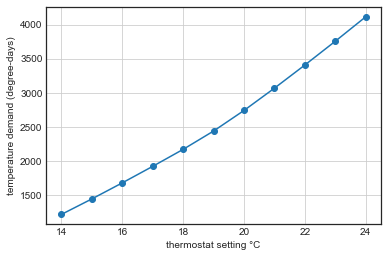

In [3]:
degree_days = []
thermostat_settings = np.arange(14, 25)
for thermostat_setting in thermostat_settings:
    y1 = temp_vals * 0 + thermostat_setting
    y2 = np.min(np.c_[temp_vals, y1], axis=1)
    avg_deg_days = np.trapz(thermostat_setting - y2, np.arange(y2.size), dx=1)
    degree_days.append(avg_deg_days)

s = pd.Series(degree_days, pd.Index(thermostat_settings, name="thermostat setting °C"), name="temperature demand")

print(s)

s.plot(marker="o", ylabel="temperature demand (degree-days)")
plt.grid()

As you can see, increase the thermostat increases the demand, in a slightly non-linear way.

How much does the demand change if we increase our thermostat by 1 degree?

In [4]:
print(f"average demand increase for 1°C: {s.diff().mean():.1f} degree-days")

s.diff()

average demand increase for 1°C: 290.2 degree-days


thermostat setting °C
14           NaN
15    227.429167
16    235.770833
17    242.560417
18    249.331250
19    269.027083
20    302.145833
21    327.258333
22    339.877083
23    349.427083
24    358.766667
Name: temperature demand, dtype: float64

As you can see, an increase of 1 degree incurs 300 degree-days more demand, on average. This looks reasonable since it means increasing the heating during the cold days by 1 degree over roughly 365 days.

With the temperature demand in place, let’s now turn to house leakiness.

# Part 2: computing the leakiness of the house

The leakiness of my house is made of two parts: conduction losses and ventilation losses.

Luckily for me, I got an energy assessement file when I bought the house which states surfaces and thermal resistances. This is what I will use to sum the leaks over all the elements of the house (walls, roof, floor).

In [5]:
df_leakiness_conduction = pd.read_excel("house_leakiness.xlsx", sheet_name="conduction",usecols=(0, 1, 2)).dropna()

df_leakiness_conduction["leakiness (W/°C)"] = df_leakiness_conduction["Surface (m²)"] * df_leakiness_conduction["U (W/m²/°C)"]

df_leakiness_conduction

,Element,Surface (m²),U (W/m²/°C),leakiness (W/°C)
0,Murs,61.00,0.36,21.960
1,Planchers,37.00,2.00,74.000
2,Plafonds,34.00,0.20,6.800
3,Fenêtre 1 (cuisine),1.26,2.60,3.276
4,Fenêtre 2 (salle de bain),0.30,2.60,0.780
5,Fenêtre 3 (chambre petite),0.30,2.60,0.780
6,Fenêtre 4 (chambre),1.93,2.60,5.018
7,Fenêtre 5 (salon),3.68,2.60,9.568
8,Fenêtre 6 (salon),2.42,2.60,6.292
9,Fenêtre 7 (vélux 1),1.26,2.80,3.528


Looking at the above table, it seems that we are leaking energy mostly through our floor and then through our walls, but not so much through our roof. But it seems to me that some of these numbers could be wrong (for instance the surface of the roof seems strangely small, at 34 m² — the floor also, at only 37 m²).

Concerning the ventilation losses, I’ve guesstimated some values for it.

In [6]:
df_leakiness_ventilation = pd.read_excel("house_leakiness.xlsx", sheet_name="ventilation",usecols=(0, 1, 2)).dropna()

df_leakiness_ventilation["leakiness (W/°C)"] = 1/3 * df_leakiness_ventilation["Volume (m³)"] * df_leakiness_ventilation["N (nombre par heure)"]

df_leakiness_ventilation

,Pièce,Volume (m³),N (nombre par heure),leakiness (W/°C)
0,Chambres,24.00,0.5,4.000000
1,Cuisine,16.80,2.0,11.200000
2,Salon,59.40,2.0,39.600000
3,Autres,72.25,0.5,12.041667


In [7]:
total_leakiness = df_leakiness_conduction["leakiness (W/°C)"].sum() + df_leakiness_ventilation["leakiness (W/°C)"].sum()

total_leakiness

209.02166666666665

# Part 3: the final "hot air" heat loss

Let’s now compute the hours of heating per day. We have a different heating schedule during the week and on weekends:

In [8]:
hours_per_day = (8 * 5 + 12 * 2) / 7 # weekdays + week-end 

hours_per_day

9.142857142857142

In [9]:
total_heating_needed = total_leakiness * s[20] * hours_per_day / 1000

print(f"Total energy needed per year: {total_heating_needed:.1f} kWh")

Total energy needed per year: 5234.9 kWh


Another question we can ask is what the yearly energy loss is as a function of thermostat value?

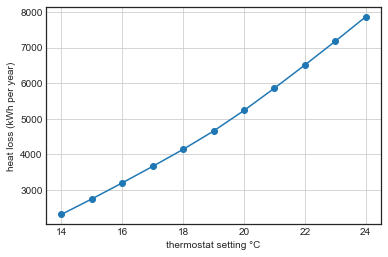

In [10]:
s2 = total_leakiness * s * hours_per_day / 1000
s2.plot(marker="o", ylabel="heat loss (kWh per year)")
plt.grid()

# Discussion 

Since our thermostat value is around 20°C, the estimated heat losses of our house are at 5200 kWh per year. It turns out that the energy inventory data we got when we bought the house mentions a number of 5374 kWh per year. However, based on the temporary data from our heating consumption, it seems we burn 1.9 tonnes of pellets per year, which would put the energy used at 9500 kWh, a value markedly above the one we computed. To be fair in the comparison, we should take into account hot water production too.

There are many moving parts here, but my main take-away is that the number we come up with here is close to the one that stands in our energy inventory file, but far from the one estimated by heating fuel costs. It will be interesting to reconcile this computation with reality and use it as a basis for estimating the possible gains due to insulation.

*This notebook is part of the repo https://github.com/flothesof/orsay_house_thermics. BSD license applies.*